# Benchmarking 2D / 3D PORTRAITS + Correlation diagrams + Correlation factors 
--------

In [1]:
# import
from multidimvis_main import *

### TOY NETWORKS

In [38]:
# TREE GRAPH
organism = 'tree'
n = 100 # number of nodes
r = 20 # branching factor
G = nx.full_rary_tree(r, n)

# STAR GRAPH
#organism = 'star'
#n = 1000
#G = nx.star_graph(n)

# CYCLE GRAPH
#organism = 'cycle'
#n = 1000
#G = nx.cycle_graph(n)

### GEOMETRIES 

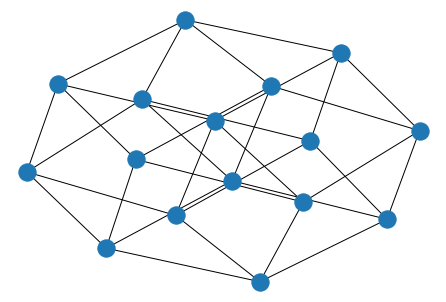

In [37]:
# Torus 
organism = 'torus'
torus_edges = [(0,1),(1,2),(2,3),(3,0),(1,5),(2,6),(0,4),(3,7),
               (4,5),(5,6),(6,7),(7,4),(5,9),(6,10),(4,8),(7,11),
              (8,9),(9,10),(10,11),(8,11),(11,15),(8,12),(9,13),(10,14),
              (12,13),(13,14),(14,15),(15,12),(12,0),(13,1),(14,2),(15,3)]
G_torus = nx.Graph()
G_torus.add_edges_from(torus_edges)
nx.draw(G_torus)

G = G_torus

In [6]:
# 3D cube
organism = '3Dcube'

cube_edges = [(0,1),(0,2),(2,3),(1,3),(2,6),(3,7),(6,7),(5,7),(1,5),(4,5),(4,0),(6,4)]
G_cube = nx.Graph()
G_cube.add_edges_from(cube_edges)

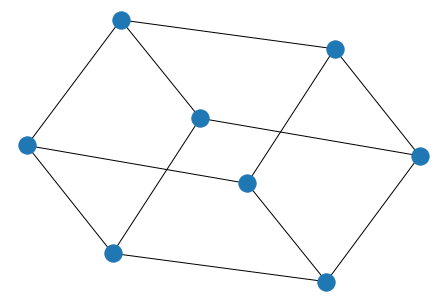

In [7]:
nx.draw(G_cube)

## NETWORK

In [39]:
print('Number of nodes i.e. genes: %s' %len(list(G.nodes())))
print('Number of edges: %s' %len(list(G.edges())))
print('Network density: %.1f%%' %(200.*len(list(G.edges()))/(len(list(G.nodes()))*len(list(G.nodes()))-1)))

Number of nodes i.e. genes: 100
Number of edges: 99
Network density: 2.0%


+ Feature Collection 

In [40]:
# DEGREE CENTRALITY - Node degree: important nodes being involved within high number of interactions
degs = dict(G.degree())
d_deghubs = {}
for node, de in sorted(degs.items(),key = lambda x: x[1], reverse = 1):
    d_deghubs[node] = round(float(de/max(degs.values())),4)
    
# CLOSENESS CENTRALITY - Measures how closely a node is connected to all other nodes to highlight f.ex. core-periphery structure, or identify central nodes
closeness = nx.closeness_centrality(G)
d_clos = {}
for node, cl in sorted(closeness.items(), key = lambda x: x[1], reverse = 1):
    d_clos[node] = round(cl,4)
    
# BETWEENESS CENTRALITY - How many shortest paths between pairs of other nodes in the network go through one node. High BC indicates "bottleneck nodes" in the network
betweens = nx.betweenness_centrality(G)
d_betw = {}
for node, be in sorted(betweens.items(), key = lambda x: x[1], reverse = 1):
     d_betw[node] = round(be,4)
    
# EIGENVECTOR CENTRALITY - Compute the eigenvector centrality for the graph
eigen = nx.eigenvector_centrality(G)
d_eigen = {}
for node, eig in sorted(eigen.items(), key = lambda x: x[1], reverse = 1):
     d_eigen[node] = round(eig,4)

In [41]:
d_deghubs_sorted = {key:d_deghubs[key] for key in sorted(d_deghubs.keys())}
d_clos_sorted = {key:d_clos[key] for key in sorted(d_clos.keys())}
d_betw_sorted = {key:d_betw[key] for key in sorted(d_betw.keys())}
d_eigen_sorted = {key:d_eigen[key] for key in sorted(d_eigen.keys())}

# feature collection
feature_dict = dict(zip(d_deghubs_sorted.keys(), zip(
                                                     d_deghubs_sorted.values(), 
                                                     d_clos_sorted.values(), 
                                                     d_betw_sorted.values(), 
                                                     d_eigen_sorted.values(),
                                                    )))

# IMPORTANT :
# sort all feature according to Graph node IDs
feature_dict_sorted = {key:feature_dict[key] for key in G.nodes()}
feature_df = pd.DataFrame.from_dict(feature_dict_sorted, orient = 'index', columns = ['degs', 
                                                                                      'clos', 
                                                                                      'betw', 
                                                                                      'eigen',
                                                                                      ]) 

In [42]:
feature_df.head()

,degs,clos,betw,eigen
0,0.9524,0.5562,0.8310,0.5029
1,1.0000,0.4195,0.3649,0.3073
2,1.0000,0.4195,0.3649,0.3073
3,1.0000,0.4195,0.3649,0.3073
4,0.9524,0.4160,0.3486,0.2759


+ Matrices

In [43]:
# Adjacency
A = nx.adjacency_matrix(G)
adj = A.toarray()
DM_adj = pd.DataFrame(adj, columns = list(G.nodes()), index=list(G.nodes()))

In [44]:
DM_adj.head() 

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [45]:
r = .8 # restart probability; originally 0.8
alpha = 1.0

DM_m = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))

DM_m_df = pd.DataFrame(DM_m)
# DM_m_df.sum(axis=0)

DM_m_transposed = DM_m_df.T
DM_m_transposed.index = list(G.nodes())

metric = "cosine" 
DM_m_new = pd.DataFrame(distance.squareform(distance.pdist(DM_m_transposed, metric)))

DM_m = pd.DataFrame(DM_m_new, columns = list(G.nodes()), index=list(G.nodes()))

In [46]:
DM_m.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.979764,0.979764,0.979764,0.979273,0.788022,0.788022,0.788022,0.788022,0.788022,...,0.995684,0.995684,0.995684,0.995684,0.995684,0.995684,0.995684,0.995684,0.995684,0.995684
1,0.979764,0.000000,0.999699,0.999699,0.999689,0.995812,0.995812,0.995812,0.995812,0.995812,...,0.999936,0.999936,0.999936,0.999936,0.999936,0.999936,0.999936,0.999936,0.999936,0.999936
2,0.979764,0.999699,0.000000,0.999699,0.999689,0.995812,0.995812,0.995812,0.995812,0.995812,...,0.999936,0.999936,0.999936,0.999936,0.999936,0.999936,0.999936,0.999936,0.999936,0.999936
3,0.979764,0.999699,0.999699,0.000000,0.999689,0.995812,0.995812,0.995812,0.995812,0.995812,...,0.999936,0.999936,0.999936,0.999936,0.999936,0.999936,0.999936,0.999936,0.999936,0.999936
4,0.979273,0.999689,0.999689,0.999689,0.000000,0.995708,0.995708,0.995708,0.995708,0.995708,...,0.786879,0.786879,0.786879,0.786879,0.786879,0.786879,0.786879,0.786879,0.786879,0.786879


In [47]:
metric = "cosine" 
DM_cent = pd.DataFrame(distance.squareform(distance.pdist(feature_df, metric)))

In [48]:
DM_cent.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.056076,0.056076,0.056076,0.056820,0.468505,0.468505,0.468505,0.468505,0.468505,...,0.471861,0.471861,0.471861,0.471861,0.471861,0.471861,0.471861,0.471861,0.471861,0.471861
1,0.056076,0.000000,0.000000,0.000000,0.000215,0.487678,0.487678,0.487678,0.487678,0.487678,...,0.478804,0.478804,0.478804,0.478804,0.478804,0.478804,0.478804,0.478804,0.478804,0.478804
2,0.056076,0.000000,0.000000,0.000000,0.000215,0.487678,0.487678,0.487678,0.487678,0.487678,...,0.478804,0.478804,0.478804,0.478804,0.478804,0.478804,0.478804,0.478804,0.478804,0.478804
3,0.056076,0.000000,0.000000,0.000000,0.000215,0.487678,0.487678,0.487678,0.487678,0.487678,...,0.478804,0.478804,0.478804,0.478804,0.478804,0.478804,0.478804,0.478804,0.478804,0.478804
4,0.056820,0.000215,0.000215,0.000215,0.000000,0.478348,0.478348,0.478348,0.478348,0.478348,...,0.468096,0.468096,0.468096,0.468096,0.468096,0.468096,0.468096,0.468096,0.468096,0.468096


In [189]:
feature = 'adj'
DM = DM_adj

#feature = 'rwr'
#DM = DM_m

#feature = 'cent'
#DM = DM_cent

____________
# 3 | SET VISUAL PRE-SETTINGS
____________

### GENERAL NODE + EDGE PARAMETERS

In [190]:
# Node, Edge colors

edge_width = 2
edge_col = 'lightgrey'
edge_colordark = 'dimgrey'
opacity_edges = 1

opacity_nodes = 1.0
node_edge_col = None


# Node sizes 

scalef= 0.2
size = list(draw_node_degree(G, scalef).values())

scalef= 0.05
size3d = list(draw_node_degree_3D(G, scalef).values())

### SPECIFIC NODE + EDGE PARAMETERS

In [191]:
# ----------------------------------------------------        
# Define colour parameter with dict (gradient)
# ----------------------------------------------------        
color_method = 'degree'
d_to_be_coloured = d_deghubs # dict sorted by dict.values (that way the biggest value matches darkest colour of palette)


# Colouring
colour_groups = set(d_to_be_coloured.values())
colour_count = len(colour_groups)
pal = sns.color_palette('Reds', colour_count)
palette = pal.as_hex()

d_colourgroups = {}
for n in colour_groups:
    d_colourgroups[n] = [k for k in d_to_be_coloured.keys() if d_to_be_coloured[k] == n]
    
d_colourgroups_sorted = {key:d_colourgroups[key] for key in sorted(d_colourgroups.keys())}

d_val_col = {}
for idx,val in enumerate(d_colourgroups_sorted):
    for ix,v in enumerate(palette):
        if idx == ix:
            d_val_col[val] = v
d_node_colour = {}
for y in d_to_be_coloured.items(): # y[0] = node id, y[1] = val
    for x in d_val_col.items(): # x[0] = val, x[1] = (col,col,col)
        if x[0] == y[1]:
            d_node_colour[y[0]]=x[1]
            
# SORT dict based on G.nodes
d_node_colour_sorted = dict([(key, d_node_colour[key]) for key in G.nodes()])

l_col_clos = list(d_node_colour_sorted.values())

colours_hex = l_col_clos 


d_val_col = {}
for idx,val in enumerate(d_colourgroups_sorted):
    for ix,v in enumerate(pal):
        if idx == ix:
            d_val_col[val] = v
d_node_colour = {}
for y in d_to_be_coloured.items(): # y[0] = node id, y[1] = val
    for x in d_val_col.items(): # x[0] = val, x[1] = (col,col,col)
        if x[0] == y[1]:
            d_node_colour[y[0]]=x[1]
            
# SORT dict based on G.nodes
d_node_colour_sorted = dict([(key, d_node_colour[key]) for key in G.nodes()])

l_col = list(d_node_colour_sorted.values())
colours = l_col

# 2D PORTRAITS

### SPRING

In [192]:
%%time 

# ---------------------------------------
# Spring
# ---------------------------------------
forceatlas2 = ForceAtlas2()
#posG_spring = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=200)
posG_spring2D = nx.spring_layout(G, dim = 2)
posG_spring3D = nx.spring_layout(G, dim = 3)

CPU times: user 42.1 ms, sys: 2.64 ms, total: 44.8 ms
Wall time: 43.6 ms


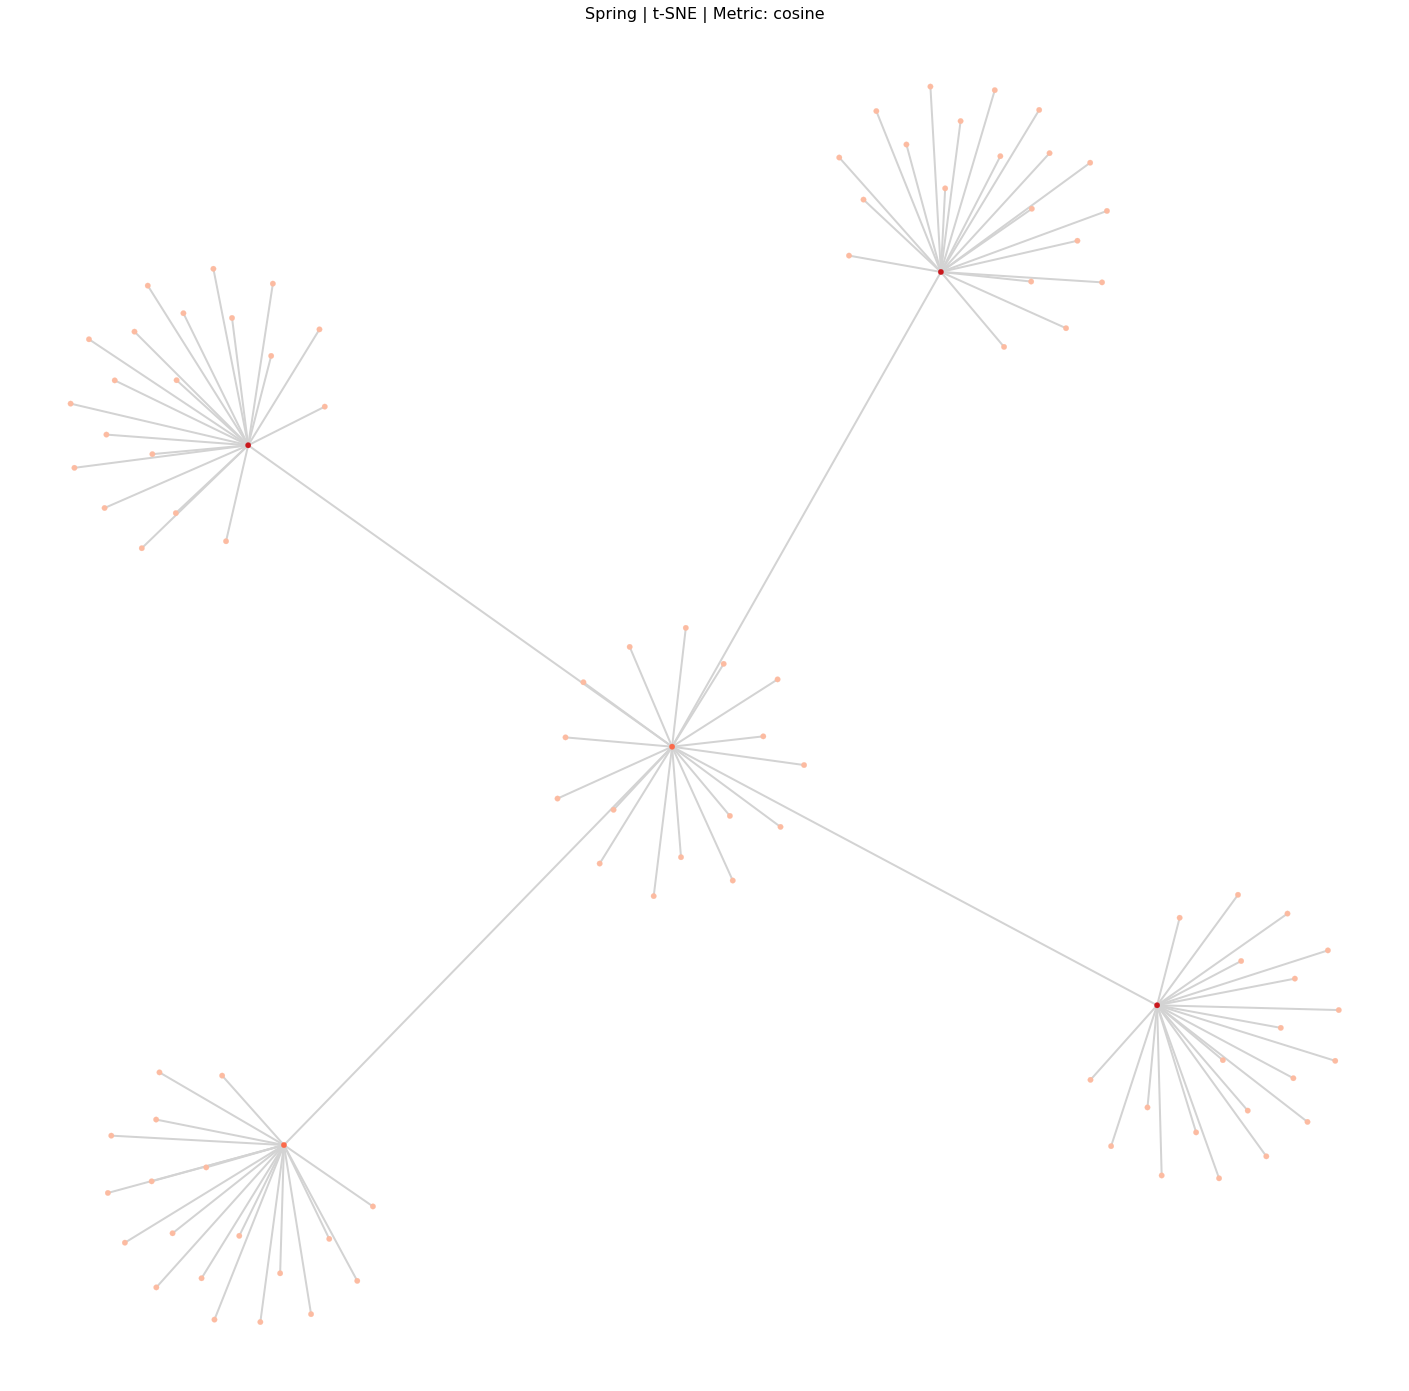

In [193]:
plt.figure(figsize=(25,25))
plt.title('Spring | t-SNE | Metric: '+metric, size= 16)

nx.draw_networkx_nodes(G, posG_spring2D, edgecolors = node_edge_col, linewidths = 0.25, node_color = colours, 
                       node_size= 30, #size, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_spring2D, width = edge_width, edge_color = edge_col, alpha = opacity_edges)

plt.box(False)

plt.savefig('output_plots/2Dspring.png')

plt.show()

### UMAP 

In [194]:
n_neighbors = 20 # balance between local and global structure in the data
spread = 50
min_dist = 0.1 # defines how dense points are stacked together 
metric ='cosine'

In [195]:
%%time 
umap = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric)

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



CPU times: user 2.87 s, sys: 191 ms, total: 3.06 s
Wall time: 1.77 s


In [196]:
posG_umap = get_posG_2D(G.nodes(), umap)
posG_complete_umap = {key:posG_umap[key] for key in G.nodes()}

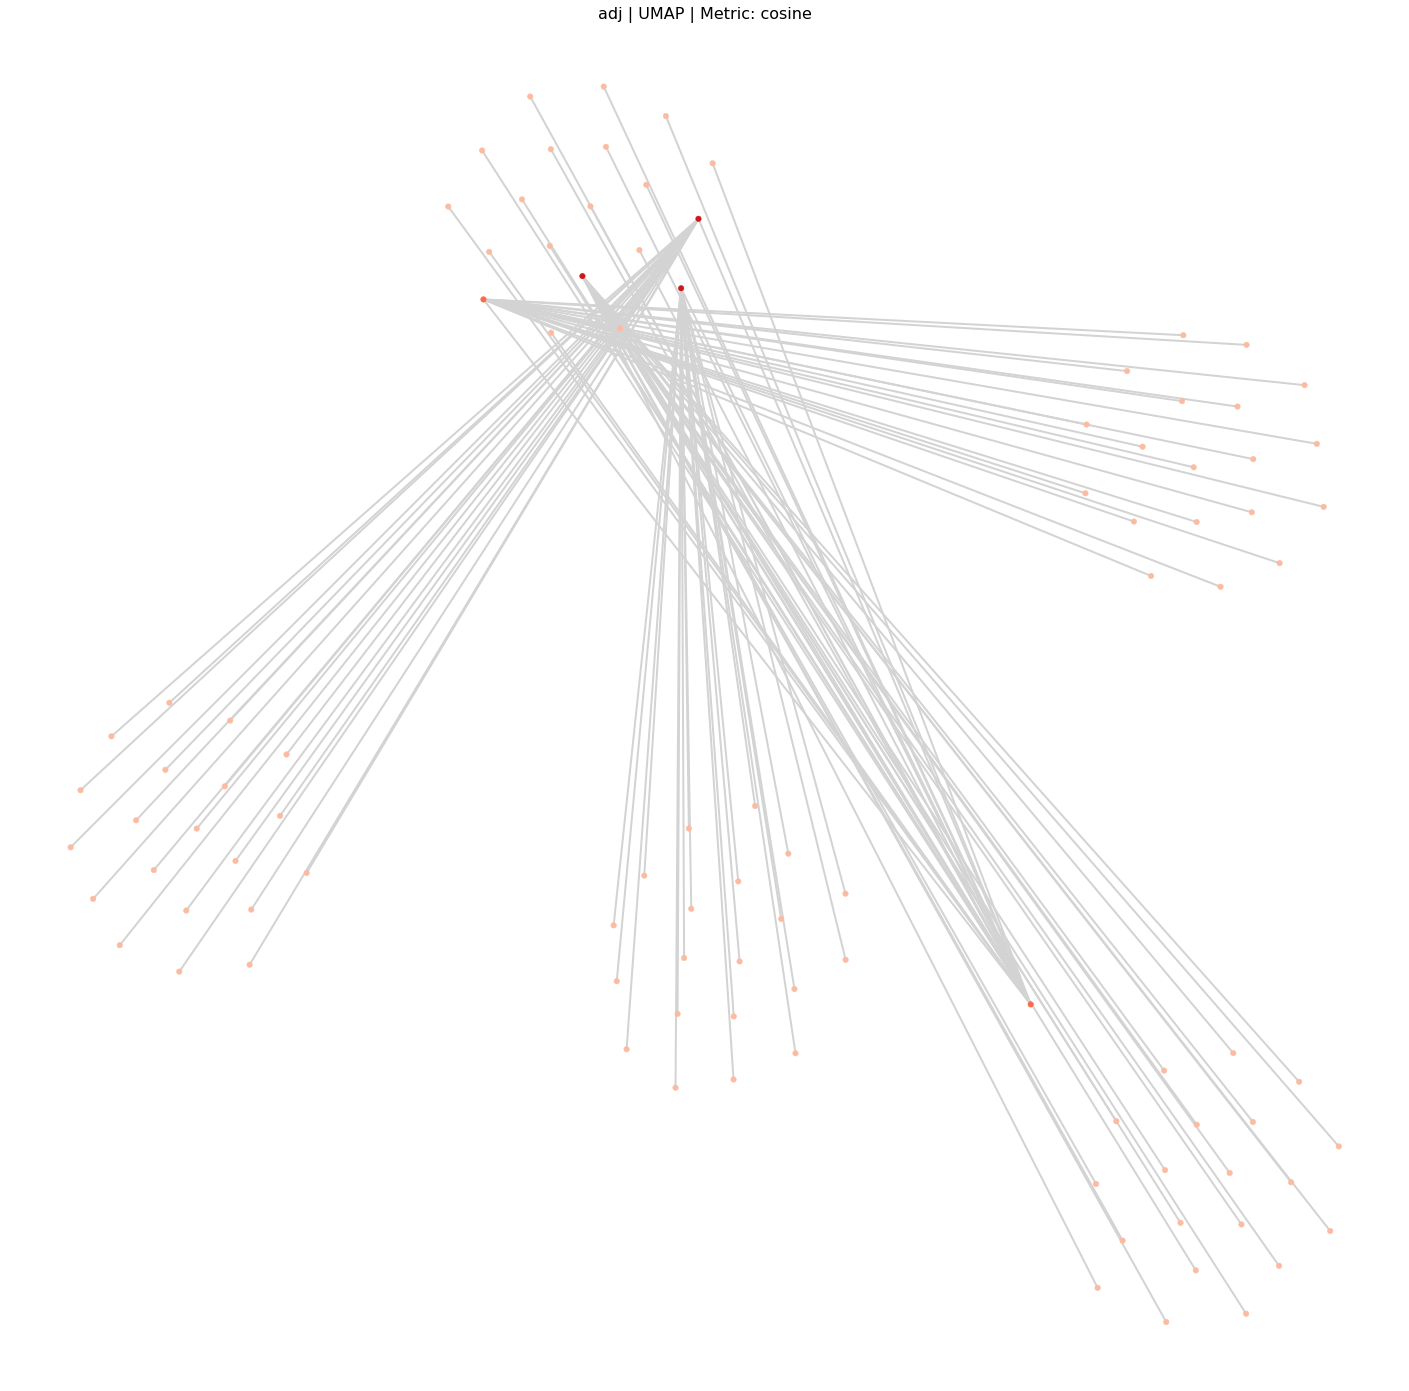

In [197]:
plt.figure(figsize=(25,25))
plt.title(feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_complete_umap, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, 
                       node_size = 30, #size, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_umap, width = edge_width, edge_color = edge_col, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dtoynetworkumap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')

plt.show()

# 3D SPRING

In [198]:
spring_nodes = get_trace_nodes_3D(posG_spring3D, None, colours, 4) #size3d)
spring_edges = get_trace_edges_3D(G, posG_spring3D, edge_col, opac=1)

spring_data = [spring_nodes, spring_edges]

In [199]:
print('Spring Layout:', organism)

fig = pgo.Figure()
for i in spring_data:
    fig.add_trace(i)
fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                    dragmode="turntable",
                    #annotations=annotations,
                ))
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_'+'spring_'+organism+'.html', auto_open=True)

Spring Layout: tree


'output_plots/3Dtoynetwork_spring_tree.html'

# 3D PORTRAITS

### UMAP 

In [200]:
n_neighbors = 20 # balance between local and global structure in the data
spread = 100
min_dist = 0.1 # defines how dense points are stacked together 
metric='cosine'

In [201]:
%%time 
umap_3D = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



CPU times: user 3.18 s, sys: 272 ms, total: 3.45 s
Wall time: 2.07 s


In [202]:
posG_3Dumap = get_posG_3D(list(G.nodes()), umap_3D)
posG_3D_complete_umap = {key:posG_3Dumap[key] for key in G.nodes()}

In [203]:
%%time 
umap_nodes = get_trace_nodes_3D(posG_3D_complete_umap, None, colours, 2) # size3d)
umap_edges = get_trace_edges_3D(G, posG_3D_complete_umap, edge_col, 0.3) 

umap_data = [umap_edges, umap_nodes]
#umap_data = [umap_nodes]

CPU times: user 7.5 ms, sys: 535 µs, total: 8.03 ms
Wall time: 7.75 ms


In [204]:
fig = pgo.Figure()
for i in umap_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    

#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_umap_'+feature+'_'+organism+'.html', auto_open=True)

'output_plots/3Dtoynetwork_umap_adj_tree.html'

_________

# EVALUATION OF Layouts compared to Spring
### CALCULATE DISTANCES OF NODES IN LAYOUTS
+ Plots to test "Original Distances" with embedded Distances 
+ X-axis = distances of layout, Y-axis = actual Distance Matrix Distances

In [205]:
def calc_dist_2D(posG):
    
    l_x= []
    l_y=[]
    for coords in posG.values():
            l_x.append(coords[0])
            l_y.append(coords[1])
            
    p_dist = []
    for idx,val in enumerate(l_x):
        d_list = []
        for c in range(len(l_x)):
            for yy in l_y:
                d = np.sqrt((l_x[idx]-l_x[c])**2+(l_y[idx]-l_y[c])**2)
            d_list.append(d)
        p_dist.append(d_list)
        
    return p_dist


def calc_dist_3D(posG):
    
    l_x = []
    l_y = []
    l_z = []
    for coords in posG.values():
            l_x.append(coords[0])
            l_y.append(coords[1])
            l_z.append(coords[2])
            
    p_dist = []
    for idx,val in enumerate(l_x):
        d_list = []
        for c in range(len(l_x)):
            for yy in l_y:
                d = np.sqrt((l_x[idx]-l_x[c])**2+(l_y[idx]-l_y[c])**2+(l_z[idx]-l_z[c])**2)
            d_list.append(d)
        p_dist.append(d_list)
        
    return p_dist

In [206]:
'''
Get trace 2D.
Used for distance functions (2D; benchmarking) 
'''
def get_trace_xy(x,y,trace_name,colour):
    trace = pgo.Scatter(
        name = trace_name,
    x = x,
    y = y,
    mode='markers',
    marker=dict(
        size=3,
        color=colour
    ),)
    return trace

## 2D layouts Correlation diagrams 

In [207]:
%%time 

# Distance from embeded Spring layout 
dist_coordinates_spring = calc_dist_2D(posG_spring2D)

# Distances from embeded coordinates from matrices 
dist_coordinates_layout = calc_dist_2D(posG_complete_umap)

CPU times: user 9.69 s, sys: 60.9 ms, total: 9.76 s
Wall time: 9.82 s


In [208]:
spring_trace = [] 
for i in range(len(dist_coordinates_spring)):
    spring_trace.append(get_trace_xy(dist_coordinates_spring[i], DM[i], "Spring", "darkgrey"))

layout_trace = []
for i in range(len(dist_coordinates_layout)):
    layout_trace.append(get_trace_xy(dist_coordinates_layout[i], DM[i], feature, "coral"))

data = [
    spring_trace, 
    layout_trace]

In [209]:
# regression line SPRING
from sklearn.linear_model import LinearRegression

X_spring = dist_coordinates_spring[0]
Y_spring = DM[0]
df_spring = pd.DataFrame({'X': X_spring, 'Y':Y_spring})

reg = LinearRegression().fit(np.vstack(df_spring['X']), Y_spring)
df_spring['bestfit'] = reg.predict(np.vstack(df_spring['X']))


# regression line LAYOUT
from sklearn.linear_model import LinearRegression

X = dist_coordinates_layout[0]
Y = DM[0]
df = pd.DataFrame({'X': X, 'Y':Y})

reg = LinearRegression().fit(np.vstack(df['X']), Y)
df['bestfit'] = reg.predict(np.vstack(df['X']))

In [210]:
print('Initial Benchmarking model (Organism):', organism)

fig = pgo.Figure()
for i in data:
    for j in i:
        fig.add_trace(j)
        
# regression line 
fig.add_trace(pgo.Scatter(name='line of best fit', x=X, y=df['bestfit'], 
                          mode='lines',
                          line=dict(
                             color='red',
                             width=0.5
            ),))

fig.add_trace(pgo.Scatter(name='line of best fit', x=X_spring, y=df_spring['bestfit'], 
                          mode='lines',
                          line=dict(
                             color='dimgrey',
                             width=0.5
            ),))


fig.update_layout(template='plotly_white', showlegend=False, width=600, height = 600,
                  xaxis_title = "DM-based distance",
                  yaxis_title = "Layout-based distance"
                )    

#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/2Dtoynetwork_CorrDiagram_'+feature+'_'+organism+'.html', auto_open=False)

Initial Benchmarking model (Organism): tree


'output_plots/2Dtoynetwork_CorrDiagram_adj_tree.html'

## 3D layouts Correlation diagrams

In [211]:
# Distance from embeded Spring layout 
dist3D_coordinates_spring = calc_dist_3D(posG_spring3D)

# Distances from embeded coordinates from matrices 
dist3D_coordinates_layout = calc_dist_3D(posG_3D_complete_umap)

In [212]:
spring_trace3D = [] 
for i in range(len(dist3D_coordinates_spring)):
    spring_trace3D.append(get_trace_xy(dist3D_coordinates_spring[i], DM[i], "Spring", "darkgrey"))

layout_trace3D = []
for i in range(len(dist3D_coordinates_layout)):
    layout_trace3D.append(get_trace_xy(dist3D_coordinates_layout[i], DM[i], feature, "coral"))

data3D = [
    spring_trace3D, 
    layout_trace3D]

In [213]:
# regression line SPRING
from sklearn.linear_model import LinearRegression

X_spring3D = dist3D_coordinates_spring[0]
Y_spring3D = DM[0]
df_spring3D = pd.DataFrame({'X': X_spring3D, 'Y':Y_spring3D})

reg = LinearRegression().fit(np.vstack(df_spring3D['X']), Y_spring3D)
df_spring3D['bestfit'] = reg.predict(np.vstack(df_spring3D['X']))


# regression line LAYOUT
from sklearn.linear_model import LinearRegression

X3D = dist3D_coordinates_layout[0]
Y3D = DM[0]
df3D = pd.DataFrame({'X': X3D, 'Y':Y3D})

reg = LinearRegression().fit(np.vstack(df3D['X']), Y3D)
df3D['bestfit'] = reg.predict(np.vstack(df3D['X']))

In [214]:
print('Initial Benchmarking model (Organism):', organism)

fig3D = pgo.Figure()
for i in data3D:
    for j in i:
        fig3D.add_trace(j)
        
# regression line 
fig3D.add_trace(pgo.Scatter(name='line of best fit', x=X3D, y=df3D['bestfit'], 
                          mode='lines',
                          line=dict(
                             color='red',
                             width=0.5
            ),))

fig3D.add_trace(pgo.Scatter(name='line of best fit', x=X_spring3D, y=df_spring3D['bestfit'], 
                          mode='lines',
                          line=dict(
                             color='dimgrey',
                             width=0.5
            ),))


fig3D.update_layout(template='plotly_white', showlegend=False, width=600, height = 600,
                  xaxis_title = "DM-based distance",
                  yaxis_title = "Layout-based distance"
                )    

#py.iplot(fig3D)

plotly.offline.plot(fig3D, filename = 'output_plots/3Dtoynetwork_CorrDiagram_'+feature+'_'+organism+'.html', auto_open=False)

Initial Benchmarking model (Organism): tree


'output_plots/3Dtoynetwork_CorrDiagram_adj_tree.html'

# Statistical Test for correlation between data sets (DMs to Layouts): 
### Pearson Correlation
+ Pearson product-moment correlation coefficients
+ The relationship between the correlation coefficient matrix, R, and the covariance matrix, C
+ Value can range from -1 to 1, the closer to 1 the more positive linear correlation ( the closer to -1 the more negative linear correlation)

In [131]:
# Pearson Correlation coefficient comparison of Spring- to Layouts-coordinates

print('Number of Nodes: ', len(G.nodes()))
print('')


pearson_spring = np.corrcoef(dist_coordinates_spring,DM)
print('Spring: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_spring),4))

pearson_layout = np.corrcoef(dist_coordinates_layout,DM)
print('Layout: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_layout),4))

Number of Nodes:  100

Spring: Mean of Pearson Correlation Coefficient:  0.2058
Layout: Mean of Pearson Correlation Coefficient:  0.2105


### Spearman Correlation 
+ to summarize the strength of the linear relationship between two data samples (Rank correlation)
+ Compared to Pearson: assumes a non-gaussian distribution and less sensitive to outliers that are in the tail of both samples - because of limiting the outliers to the value of their ranks 
+ Value can range from -1 to 1, the closer to 1 the more monotonic relationship between X and Y

In [130]:
from scipy.stats import spearmanr

print('Number of Nodes: ', len(G.nodes()))
print('')

# Spearman Correlation coefficient comparison of Spring- to Layouts-coordinates

spearman_spring, _ = spearmanr(dist_coordinates_spring, DM)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spring),4))

spearman_layout, _ = spearmanr(dist_coordinates_layout, DM)
print('Layout: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_layout),4))


Number of Nodes:  100

Spring: Mean of Spearman Correlation Coefficient:  0.0787
Layout: Mean of Spearman Correlation Coefficient:  0.2153
